# Introduction

This is a python notebook which serves as a potential solution to the <a href="https://www.kaggle.com/competitions/playground-series-s4e6">kaggle competition</a>

The best score I was able to achieve was 2325/2739. 
There are a lot of improvements that can be made upon this model. Some of those are:  
- Feature Selection: One of them is actually to much more closely analyse the data and identify top 10, 20 features. 
- Try more different loss functions
- Add more layers to the neural network 
- Experiment with different <b>lower</b> learning rates. Increasing it to 0.01 will cause <b>huge</b> training losses.
- and any other you can think of !

## Library Import

In [1]:
# Importing Libraries

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

import torch.nn.functional as F

# Data Exploration. EDA

In [2]:
train = pd.read_csv("data/train.csv")

In [3]:
# first test without changing anything with the data (no pre-processing)
# creating a unique count table
col_name = []
col_count = []
for i in range(1, len(train.columns)):
    col_name.append(train.columns[i])
    col_count.append(train[train.columns[i]].nunique())

unique_count = pd.DataFrame(data={"Name": col_name, "Count": col_count})
unique_count.sort_values(by=unique_count.columns[1])

,Name,Count
18,Scholarship holder,2
20,International,2
17,Gender,2
16,Tuition fees up to date,2
4,Daytime/evening attendance,2
15,Debtor,2
14,Educational special needs,2
13,Displaced,2
36,Target,3
0,Marital status,6


In [4]:
# inspect NA vals
train.isnull().sum()

id                                                0
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship 

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

In [6]:
train["Target"].unique()

array(['Graduate', 'Dropout', 'Enrolled'], dtype=object)

In [7]:
train["Application mode"].value_counts()

Application mode
1     35227
17    16523
39    14519
44     3012
43     2671
7      1498
18     1256
42      551
51      442
16      265
53      225
15      183
5        87
10       43
2         8
27        2
12        1
26        1
4         1
35        1
9         1
3         1
Name: count, dtype: int64

In [8]:
train["Target"].value_counts()

Target
Graduate    36282
Dropout     25296
Enrolled    14940
Name: count, dtype: int64

Given how the dataset is imbalanced we may need to carry out stratified sampling in order to ensure there is no bias.

In [9]:
cat_columns = [
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Application mode",
]

In [10]:
# one hot encoding
one_hot_prevqual = pd.get_dummies(
    train,
    columns=[
        "Previous qualification",
        "Nacionality",
        "Mother's qualification",
        "Father's qualification",
        "Mother's occupation",
        "Application mode",
    ],
)

encoder = OneHotEncoder(sparse_output=False)
one_hot_prevqual = encoder.fit_transform(train[cat_columns])

one_hot_df = pd.DataFrame(
    one_hot_prevqual, columns=encoder.get_feature_names_out(cat_columns)
)
df_encoded = pd.concat([train, one_hot_df], axis=1)
df_encoded = df_encoded.drop(cat_columns, axis=1)
df_encoded

,id,Marital status,Application order,Course,Daytime/evening attendance,Previous qualification (grade),Father's occupation,Admission grade,Displaced,Educational special needs,...,Application mode_18,Application mode_26,Application mode_27,Application mode_35,Application mode_39,Application mode_42,Application mode_43,Application mode_44,Application mode_51,Application mode_53
0,0,1,1,9238,1,126.0,5,122.6,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,1,9238,1,125.0,9,119.8,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,2,9254,1,137.0,3,144.7,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,3,9500,1,131.0,2,126.1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,2,9500,1,132.0,9,120.1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,76513,1,1,9254,1,121.0,5,116.5,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76514,76514,1,6,9254,1,125.0,9,131.6,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76515,76515,5,1,9085,1,138.0,10,123.3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76516,76516,1,3,9070,1,136.0,9,124.8,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# scaling stuff proper
numerical_features = [
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (without evaluations)",
    "Unemployment rate",
    "Inflation rate",
    "GDP",
    "Application order",
]

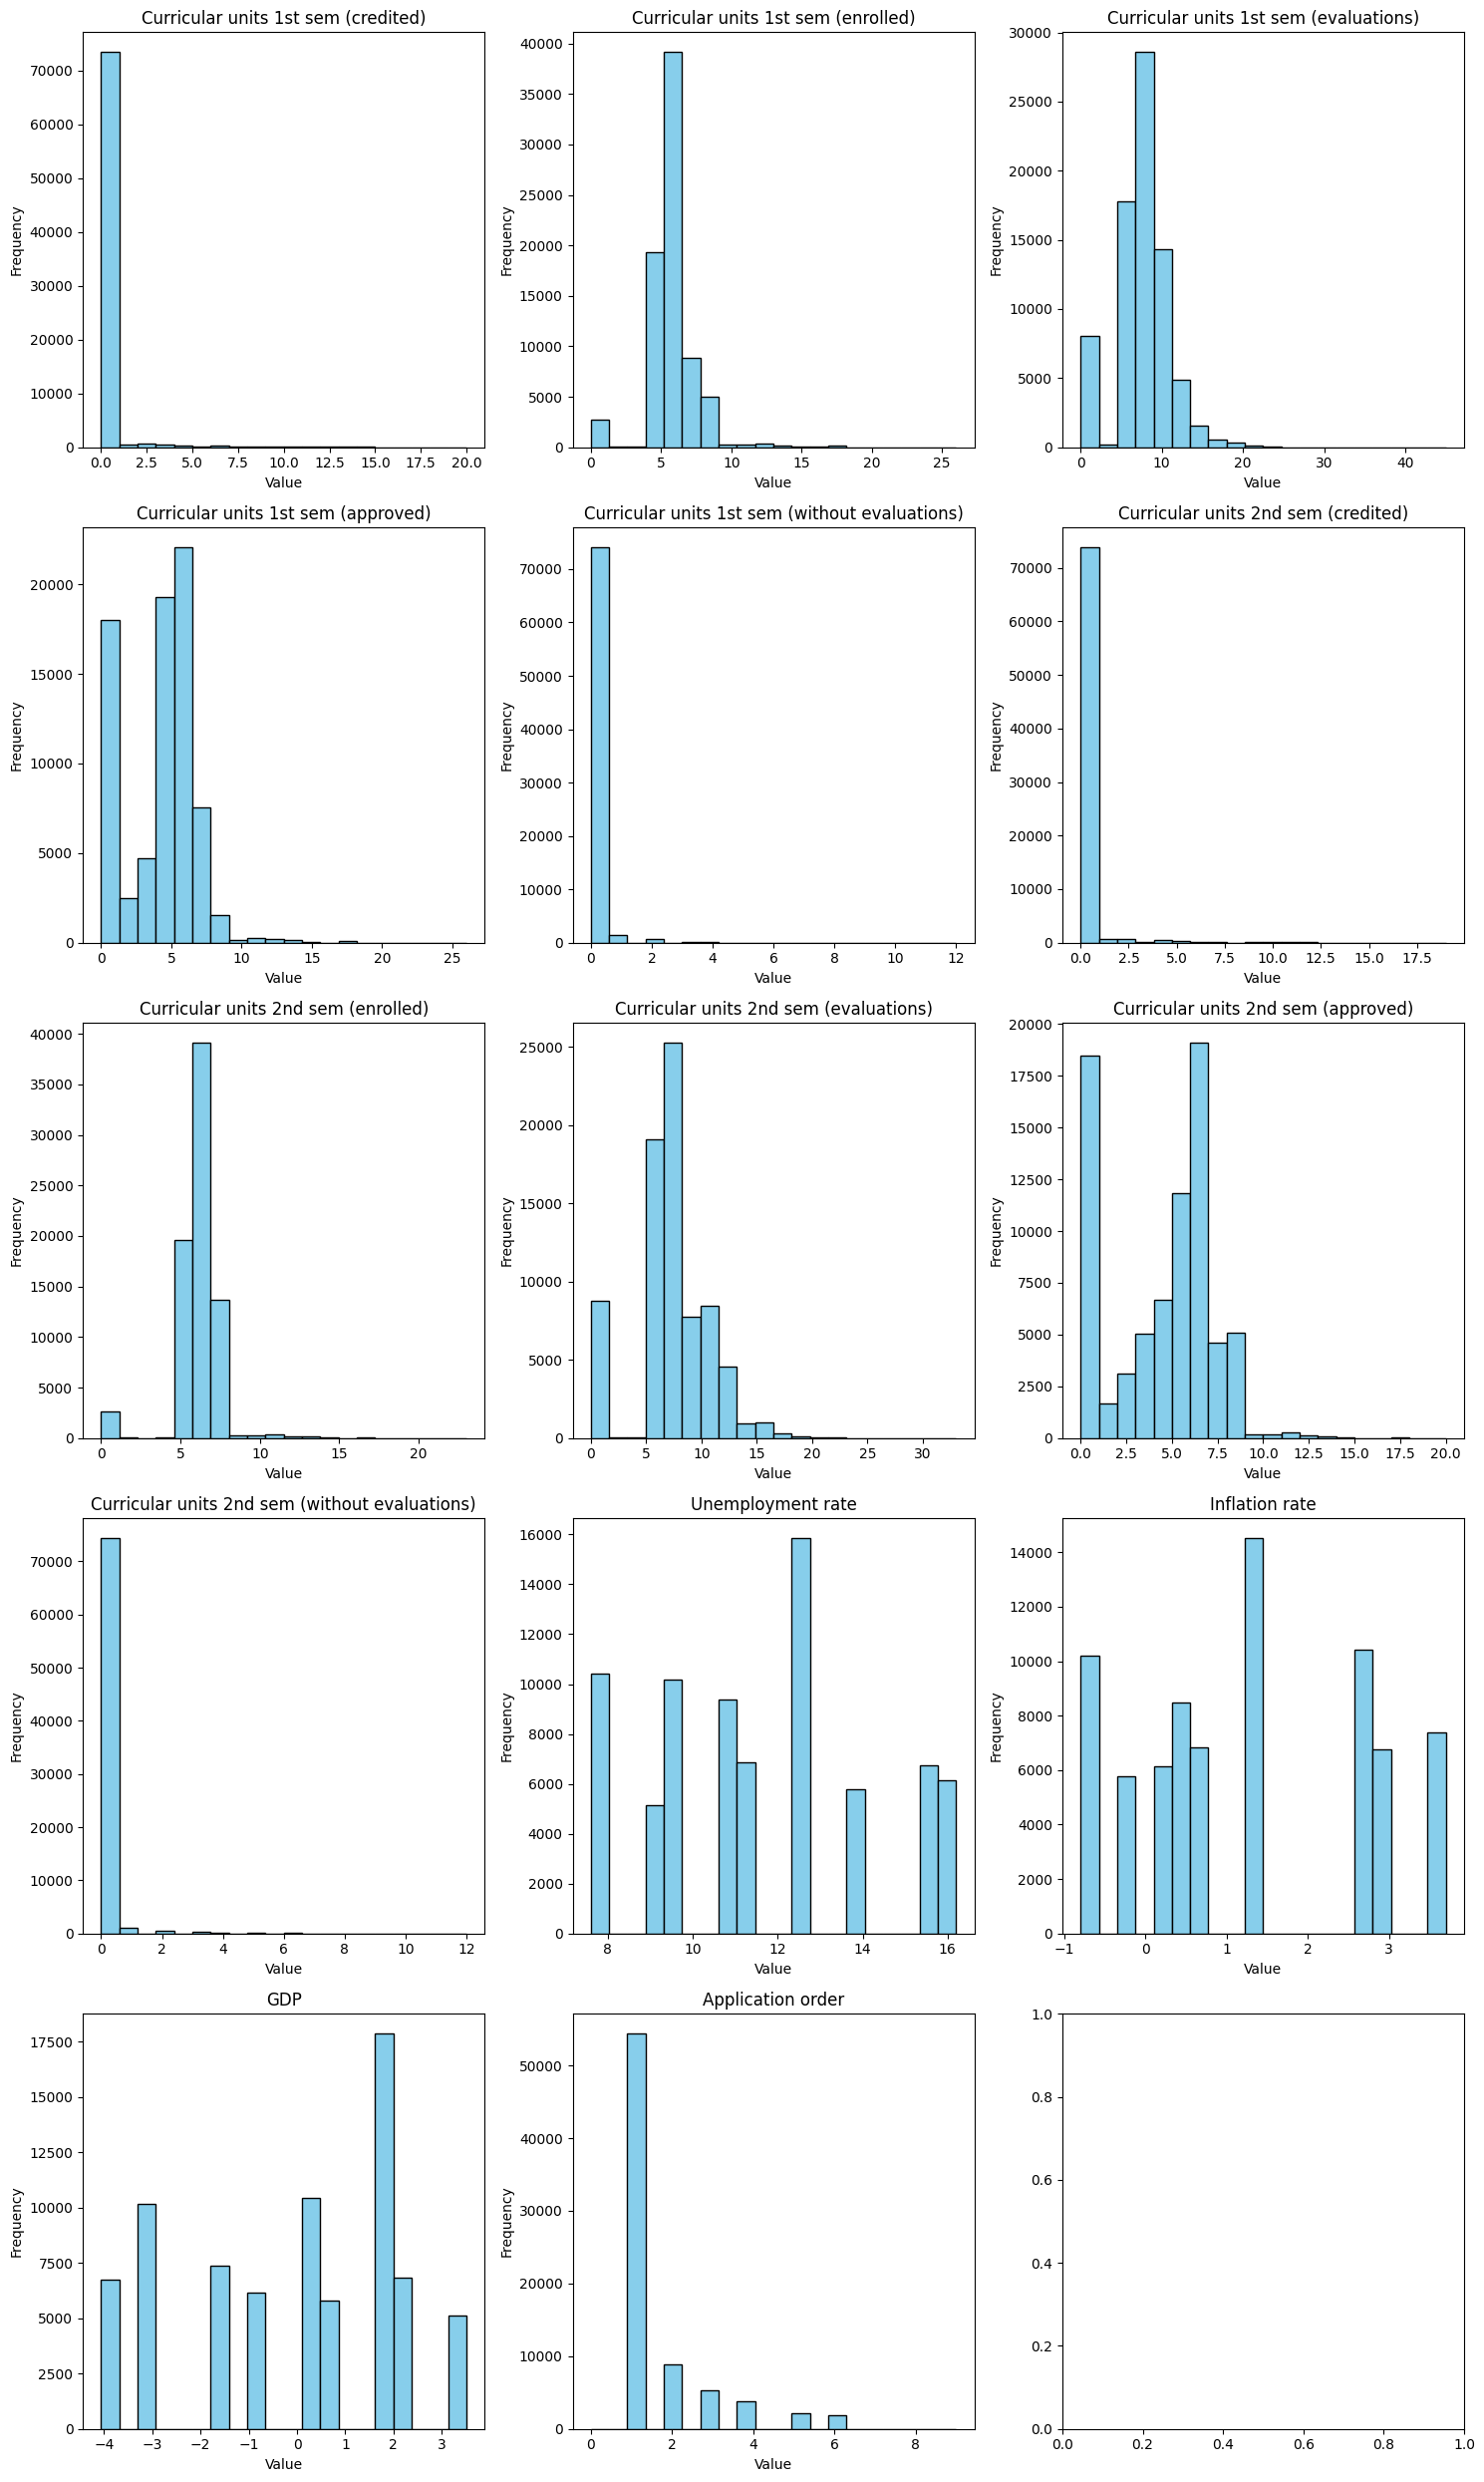

In [12]:
# fig, axs = plt.subplots(7,7, tight_layout=True)
num_plots = len(numerical_features)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array if there's only one row or column
if num_rows == 1 or num_cols == 1:
    axes = axes.flatten()

# Plot histograms for each numerical feature
for i, feature in enumerate(numerical_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.hist(df_encoded[feature], bins=20, color="skyblue", edgecolor="black")
    ax.set_title(feature)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [13]:
# for the time being we go with standard scaling
from sklearn.discriminant_analysis import StandardScaler

scaler = StandardScaler()
# Fit and transform the numerical features
scaled_numerical = scaler.fit_transform(df_encoded[numerical_features])
df_scaled = pd.DataFrame(scaled_numerical, columns=numerical_features)
# Concatenate the scaled numerical features with the existing DataFrame
df_encoded = pd.concat([df_encoded, df_scaled], axis=1)
print(df_encoded)

          id  Marital status  Application order  Course  \
0          0               1                  1    9238   
1          1               1                  1    9238   
2          2               1                  2    9254   
3          3               1                  3    9500   
4          4               1                  2    9500   
...      ...             ...                ...     ...   
76513  76513               1                  1    9254   
76514  76514               1                  6    9254   
76515  76515               5                  1    9085   
76516  76516               1                  3    9070   
76517  76517               1                  1    9773   

       Daytime/evening attendance  Previous qualification (grade)  \
0                               1                           126.0   
1                               1                           125.0   
2                               1                           137.0   
3              

In [14]:
# once scaling done check out
# plotting a correlation matrix to check which features are more strongly coorrelated
temp_train = df_encoded.replace({"Graduate": 0, "Dropout": 1, "Enrolled": 2})

correlation_matrix = temp_train.corr()
correlation_with_target = (
    correlation_matrix["Target"].abs().sort_values(ascending=False)
)

correlation_with_target

Target                                 1.000000
Curricular units 2nd sem (approved)    0.458061
Curricular units 2nd sem (approved)    0.458061
Curricular units 1st sem (approved)    0.406249
Curricular units 1st sem (approved)    0.406249
                                         ...   
Mother's occupation_1                  0.000231
Mother's occupation_3                  0.000122
Father's qualification_43              0.000120
Father's qualification_42              0.000085
Mother's qualification_12              0.000037
Name: Target, Length: 221, dtype: float64

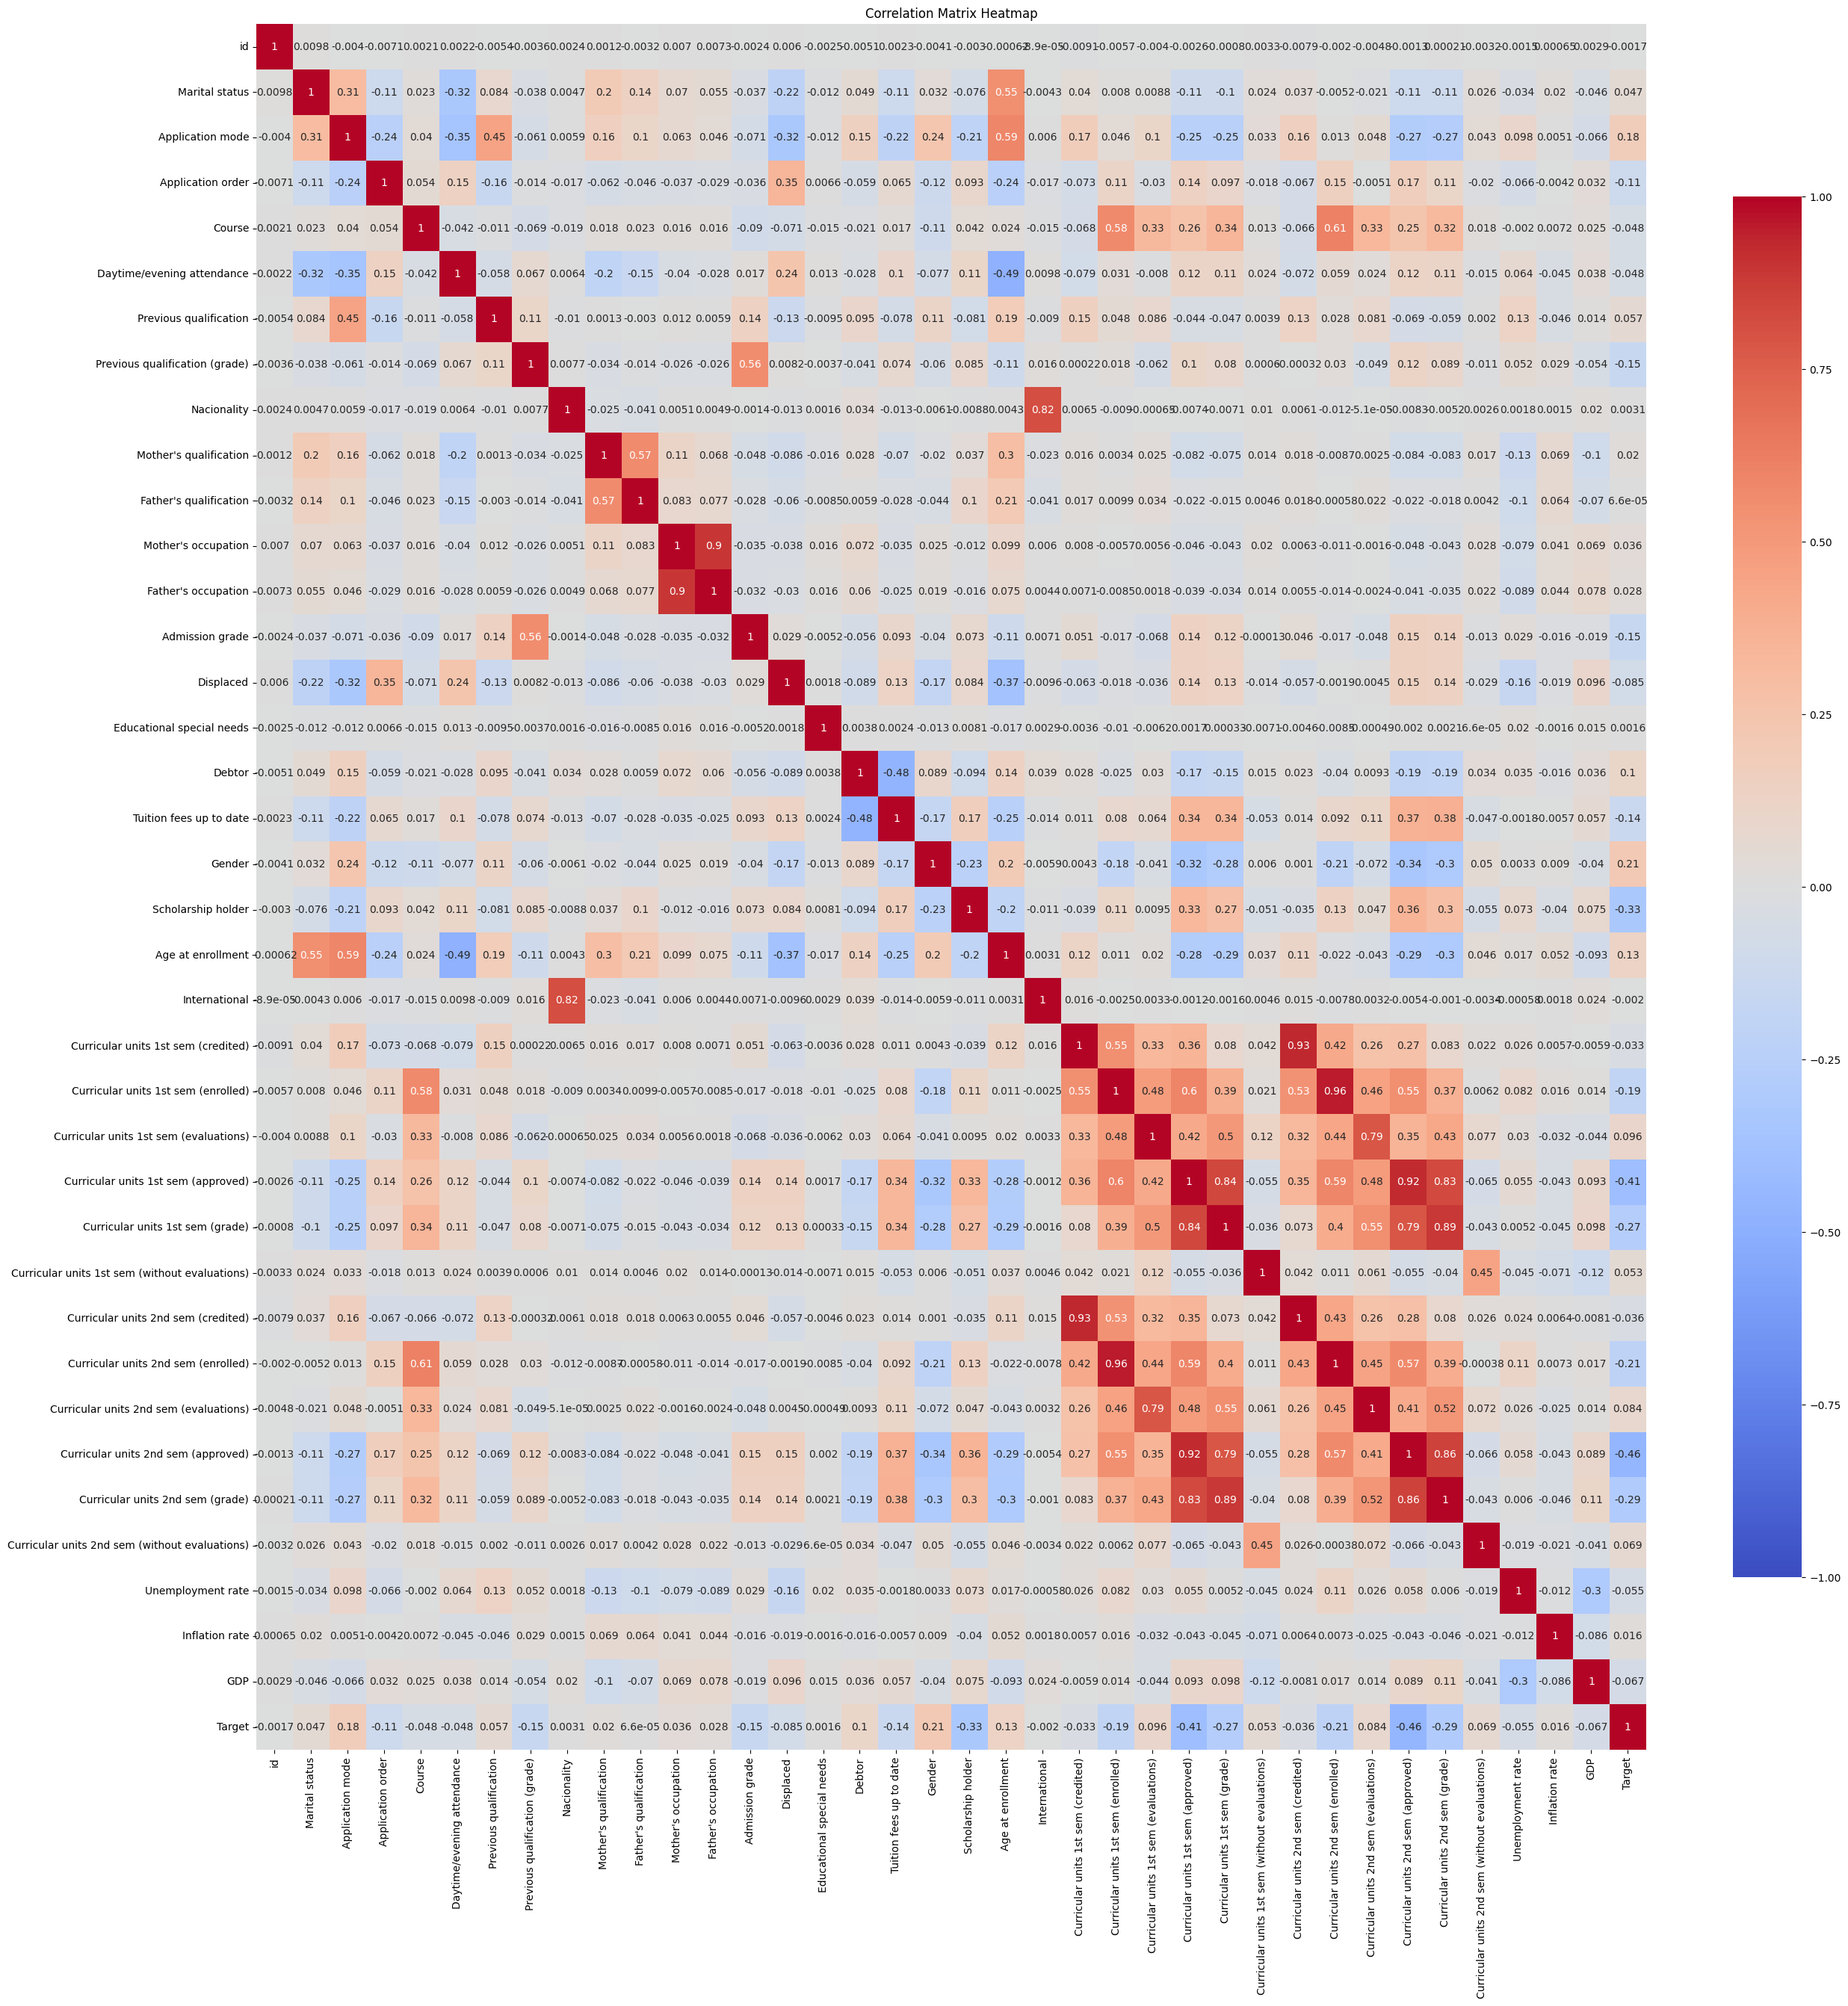

In [15]:
# plotting a correlation matrix to check which features are more strongly coorrelated
temp_train = train.replace({"Graduate": 0, "Dropout": 1, "Enrolled": 2})

correlation_matrix = temp_train.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
# lets go and convert this into tensors. then make em into Dataset object followed by batches for training since I am not in the mood to eternally crash my kernel


## Building a Pipeline for preprocessing and training neural network

Below is the pipeline which I built for preprocessing and training a neural network. Each 'class' serves as one step in the pipeline. 

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


# one hot encoding all catgeorical variables
class OneHotEncodeCols(BaseEstimator, TransformerMixin):
    # def __init__(self):
    #     self.encoder = OneHotEncoder(sparse_output=False)

    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        self.cat_columns = [
            "Previous qualification",
            "Nacionality",
            "Mother's qualification",
            "Father's qualification",
            "Mother's occupation",
            "Application mode",
        ]

    def fit(self, X, y=None):
        #
        self.encoder.fit(X[self.cat_columns])
        return self

    def transform(self, X):
        train = X.copy()
        # self.encoder.fit(train[cat_columns])
        one_hot_encoded = self.encoder.transform(train[self.cat_columns])
        one_hot_df = pd.DataFrame(
            one_hot_encoded,
            columns=self.encoder.get_feature_names_out(self.cat_columns),
            index=train.index,
        )
        df_encoded = pd.concat([train, one_hot_df], axis=1)
        df_encoded = df_encoded.drop(self.cat_columns, axis=1)
        # print(f"df_encoded: {df_encoded.shape}")
        return df_encoded


# numerical feature scaling
class StandardScaleCols(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.numerical_features = [
            "Age at enrollment",
            "Curricular units 1st sem (credited)",
            "Curricular units 1st sem (enrolled)",
            "Curricular units 1st sem (evaluations)",
            "Curricular units 1st sem (approved)",
            "Curricular units 1st sem (grade)",
            "Curricular units 2nd sem (credited)",
            "Curricular units 2nd sem (enrolled)",
            "Curricular units 2nd sem (evaluations)",
            "Curricular units 2nd sem (approved)",
            "Curricular units 2nd sem (grade)",
            "Unemployment rate",
            "Inflation rate",
            "GDP",
        ]

    # def fit(self, X, y=None):
    #     return self

    def fit(self, X, y=None):
        self.scaler.fit(X[self.numerical_features])
        return self

    def transform(self, X):
        df_encoded = X.copy()
        scaled_numerical = self.scaler.transform(df_encoded[self.numerical_features])
        df_scaled = pd.DataFrame(
            scaled_numerical, columns=self.numerical_features, index=df_encoded.index
        )
        df_encoded[self.numerical_features] = df_scaled
        return df_encoded


class ConvertToTensorDataset(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_piped = X

        # convert to tensor and make Dataset object
        if "Target" in df_piped.columns:
            X_train = df_piped.drop(["id", "Target"], axis=1)
            y_train = df_piped["Target"].replace(
                {"Graduate": 0, "Dropout": 1, "Enrolled": 2}
            )
            X_train = torch.from_numpy(X_train.values)
            y_train = torch.from_numpy(y_train.values)

            # wrapping the tensors in a dataset object
            dataset = TensorDataset(X_train, y_train)
            return dataset
        # this means its a test dataset. since test dataset does not have id or Target columns we skip those steps and convert it to a tensor.
        # NOTE: 'dtype' is crucial to the entire process of training a nn
        else:
            X_train = torch.tensor(df_piped.values, dtype=torch.float32)
            return X_train


class MLP(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=64):
        """
        input_features: Number of inputs
        output_features: Number of outputs (in classification: the number of categories)
        hidden_units: Number of neural networks in each hidden layer of network
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


class ModelTrain(BaseEstimator, TransformerMixin):
    """
    This class trains a model based on the user's inputs for each param. It allows for experimentation with different parameter value
    """

    def __init__(
        self,
        input_features,
        output_features,
        hidden_units,
        loss_fn=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        lr=0.001,
        epochs=20,
        batch_size=32,
    ):
        self.input_features = input_features
        self.output_features = output_features
        self.hidden_units = hidden_units
        self.loss_fn = loss_fn()
        self.optimizer = optimizer
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tl_array = []

    def fit(self, X, y=None):
        dataset = X
        trainloader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True, num_workers=1
        )

        device = self.device
        self.model = MLP(
            self.input_features, self.output_features, self.hidden_units
        ).to(self.device)
        optimizer = self.optimizer(self.model.parameters(), lr=self.lr)

        for epoch in range(self.epochs):
            train_loss = 0

            for batch, (X, y) in enumerate(trainloader):
                # Move the data to the correct device and dtype
                X = X.to(device).type(next(self.model.parameters()).dtype)
                y = y.to(device)
                y = y.long()

                self.model.train()

                # forward pass
                y_logits = self.model(X).squeeze()
                # softmax to get the probabilities
                pred_probs = torch.softmax(y_logits, dim=1)
                # argmax to get the predicted label
                y_pred_label = torch.argmax(pred_probs, dim=1)
                # y_pred = torch.argmax(y_pred, dim=1).float()

                # calc loss

                # print(f"y shape: {y[0]}")
                # print(f"y_pred: {y_pred[0]}")

                # print(f"y: {y}")

                loss = self.loss_fn(y_logits, y)
                train_loss += loss.item()

                # zero grad optim
                optimizer.zero_grad()

                # backward prop
                loss.backward()

                # optimizer step
                optimizer.step()

            train_loss /= len(trainloader)

            print(f"Epoch: {epoch+1} | Train loss: {train_loss}")
            self.tl_array.append(train_loss)

        return self

    def transform(self, X):
        return self.model, self.tl_array

In [30]:
# Create the pipeline

# I am actually experimenting with losses here. you can go ahead and take out the pipeline from the for loop and run it for your own params
loss_values = []
lr_array = [0.01, 0.001]
for i in lr_array:
    full_pipeline = Pipeline(
        [
            ("one_hot_encoder", OneHotEncodeCols()),
            ("standard_scaler", StandardScaleCols()),
            ("to_tensor_dataset", ConvertToTensorDataset()),
            (
                "model_trainer",
                ModelTrain(
                    input_features=205,
                    output_features=3,
                    hidden_units=256,
                    loss_fn=nn.CrossEntropyLoss,
                    optimizer=torch.optim.Adam,
                    lr=i,
                    epochs=15,
                    batch_size=16,
                ),
            ),
        ]
    )
    # Fit the pipeline
    trained_model = full_pipeline.fit_transform(train)
    loss_values.append(trained_model[1])

Epoch: 1 | Train loss: 405.8490502808524
Epoch: 2 | Train loss: 936.0499268346393
Epoch: 3 | Train loss: 472.96273502814654
Epoch: 4 | Train loss: 284.196276563697
Epoch: 5 | Train loss: 421.45490576703503
Epoch: 6 | Train loss: 536.6780799680765
Epoch: 7 | Train loss: 1050.5146642743034
Epoch: 8 | Train loss: 2971.6985318454867
Epoch: 9 | Train loss: 1135.5508767687174
Epoch: 10 | Train loss: 1504.241409464658
Epoch: 11 | Train loss: 1518.4659948790645
Epoch: 12 | Train loss: 1841.374005642691
Epoch: 13 | Train loss: 2591.4905916140615
Epoch: 14 | Train loss: 2430.7275807234923
Epoch: 15 | Train loss: 2127.8411621734135
Epoch: 1 | Train loss: 1.0559971631632523
Epoch: 2 | Train loss: 0.7991739333644836
Epoch: 3 | Train loss: 0.5674481617784104
Epoch: 4 | Train loss: 0.5487528615324486
Epoch: 5 | Train loss: 0.5458957214993386
Epoch: 6 | Train loss: 0.5479311477093051
Epoch: 7 | Train loss: 0.5385403122091652
Epoch: 8 | Train loss: 0.5401806265759077
Epoch: 9 | Train loss: 0.5310500339

In [36]:
import numpy as np


def plot_train_loss(
    loss_lists,
    labels=None,
    title="Effect of Learning Rate on Loss",
    xlabel="Epochs",
    ylabel="Loss",
    method="two_axes",
):
    """
    Plot multiple train loss curves on the same graph, handling different scales.

    Args:
    loss_lists (list of lists): A list containing lists of train loss values.
    labels (list of str, optional): Labels for each loss curve. If None, default labels will be used.
    title (str): Title of the plot.
    xlabel (str): Label for x-axis.
    ylabel (str): Label for y-axis.
    method (str): Plotting method. Options: "two_axes", "normalize", "log_scale"
    """
    plt.figure(figsize=(12, 6))

    if method == "two_axes":
        ax1 = plt.gca()
        ax2 = ax1.twinx()
        axes = [ax1, ax2]
    else:
        ax1 = plt.gca()
        axes = [ax1]

    for i, loss_list in enumerate(loss_lists):
        label = labels[i] if labels and i < len(labels) else f"Model {i+1}"
        x = range(1, len(loss_list) + 1)

        if method == "normalize":
            loss_list = (loss_list - np.min(loss_list)) / (
                np.max(loss_list) - np.min(loss_list)
            )

        if method == "log_scale":
            plt.yscale("log")

        axes[i % len(axes)].plot(x, loss_list, label=label)

    plt.title(title)
    plt.xlabel(xlabel)

    if method == "two_axes":
        ax1.set_ylabel(f"{ylabel} (Left Axis)")
        ax2.set_ylabel(f"{ylabel} (Right Axis)")
        ax1.legend(loc="upper left")
        ax2.legend(loc="upper right")
    else:
        plt.ylabel(ylabel)
        plt.legend()

    if method == "normalize":
        plt.ylabel("Normalized " + ylabel.lower())

    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

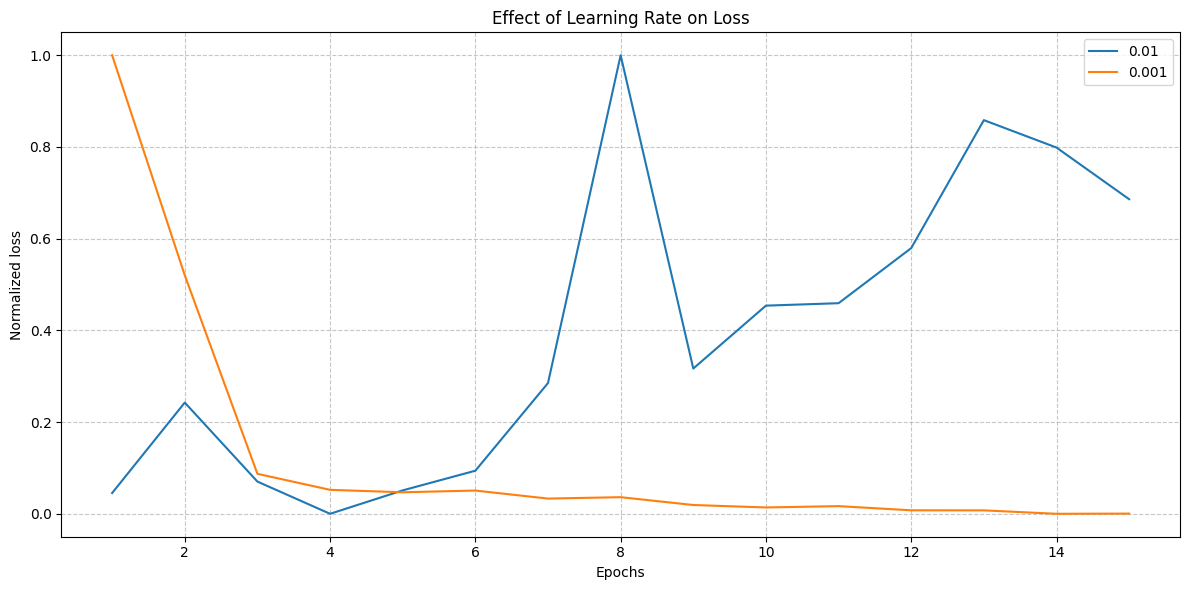

In [40]:
plot_train_loss(loss_values, ["0.01", "0.001"], method="normalize")

In [41]:
# pipeline for just one set of params
full_pipeline = Pipeline(
    [
        ("one_hot_encoder", OneHotEncodeCols()),
        ("standard_scaler", StandardScaleCols()),
        ("to_tensor_dataset", ConvertToTensorDataset()),
        (
            "model_trainer",
            ModelTrain(
                input_features=205,
                output_features=3,
                hidden_units=512,
                loss_fn=nn.CrossEntropyLoss,
                optimizer=torch.optim.Adam,
                lr=0.00001,
                epochs=15,
                batch_size=16,
            ),
        ),
    ]
)
# Fit the pipeline
trained_model, loss_array = full_pipeline.fit_transform(train)

Epoch: 1 | Train loss: 1.0869811732550183
Epoch: 2 | Train loss: 0.993457292989535
Epoch: 3 | Train loss: 0.8317882095685744
Epoch: 4 | Train loss: 0.7147249481978587
Epoch: 5 | Train loss: 0.6625564645040417
Epoch: 6 | Train loss: 0.6399315542539692
Epoch: 7 | Train loss: 0.6098225630855625
Epoch: 8 | Train loss: 0.5947153995971338
Epoch: 9 | Train loss: 0.5863967106951945
Epoch: 10 | Train loss: 0.5681583929496182
Epoch: 11 | Train loss: 0.5718803388050429
Epoch: 12 | Train loss: 0.558437345352023
Epoch: 13 | Train loss: 0.5563600989155582
Epoch: 14 | Train loss: 0.5519596628397672
Epoch: 15 | Train loss: 0.5460881243206556


In [42]:
# test dataset pipeline
# NOTE: This pipeline uses the4 same steps as the one used for preprocessing and training. I just made this pipeline since we have fewer steps as only preprocessing is required here
test_pipeline = Pipeline(
    [
        ("one_hot_encoder", OneHotEncodeCols()),
        ("standard_scaler", StandardScaleCols()),
        ("to_tensor_dataset", ConvertToTensorDataset()),
    ]
)

### Preprocessing of test dataset 

Here you will notice that for 'test_cleaned' I used 'test_pipeline.transform' and thats because we want to use the encoder and scaler that had been fit to the training set. This ensures consistency between both train and test sets. Just try using fit_transform on test dataset and you will notice a difference in number of columns and thats because both the encoder and scaler are refit just on test which causes inconsistency in between the number of features in train and test. 

The reason why I yapped abut it for so long is because I was initially very confused about this. The concept is quite simple to understand. 

In [43]:
# making predictions
test = pd.read_csv("data/test.csv")
test_cleaned = test.drop(["id"], axis=1)
train_cleaned = test_pipeline.fit_transform(train)
test_cleaned = test_pipeline.transform(test_cleaned)
# print(test_cleaned.shape)
# train_cleaned
# print(train_cleaned.shape)
with torch.inference_mode():
    y_preds = trained_model(test_cleaned)
y_preds

df = pd.DataFrame(y_preds.numpy())

df1 = pd.merge(test["id"], df, left_index=True, right_index=True)
df1

,id,0,1,2
0,76518,-3.258076,4.120815,1.375466
1,76519,3.036562,-0.598377,0.579960
2,76520,1.966830,-0.096151,1.051328
3,76521,0.530078,0.720990,1.479368
4,76522,-0.361566,1.419868,1.706947
...,...,...,...,...
51007,127525,-0.199580,1.595654,-0.787314
51008,127526,-4.964948,5.509438,1.174999
51009,127527,-0.784129,2.172006,-0.752495
51010,127528,0.171967,1.043452,1.649274


In [44]:
def give_output_ah(dataframe):
    """
    Determines category for each row in the test dataframe and saves the results to output.csv
    """
    df1 = dataframe
    # Target column mapping
    mapping = {0: "Graduate", 1: "Dropout", 2: "Enrolled"}

    # Extract the relevant columns and convert to tensor
    logits = torch.tensor(df1[[0, 1, 2]].values, dtype=torch.float32)

    # Apply the softmax function
    probabilities = F.softmax(logits, dim=1)

    # Add the probabilities back to the DataFrame
    for i in range(3):
        df1[f"prob_{i}"] = probabilities[:, i].numpy()

    # Determine the class with the highest probability
    predicted_classes = probabilities.argmax(dim=1).numpy()

    # Map the class indices to their corresponding labels
    df1["Target"] = [mapping[pred_class] for pred_class in predicted_classes]

    # print(df1.shape)
    # print(df1.head())
    df1[["id", "Target"]].to_csv("output.csv", index=False)
    # return df1


give_output_ah(df1)